# Homework 7: **Deep Learning with PyTorch**

In this homework, we'll build a model for classifying various hair types. For this, we will use the Hair Type dataset that was obtained from Kaggle and slightly rebuilt (data given by the instructor).

## 1. Package imports

In [1]:
import os
import numpy as np

from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

In [2]:
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## 2. Load images

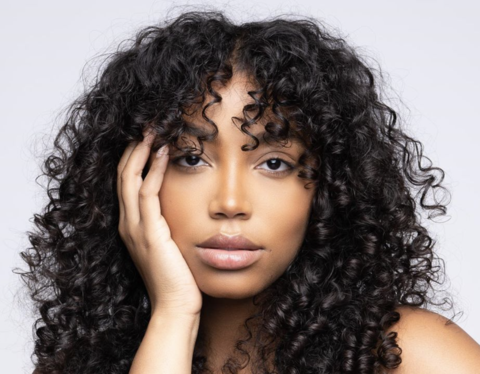

In [13]:
# Load an image
img_c = Image.open('data/hair-data/train/curly/1ead97140aa6a90385d5c9e6b7fef476.png')

# Visualize the image img
img_c

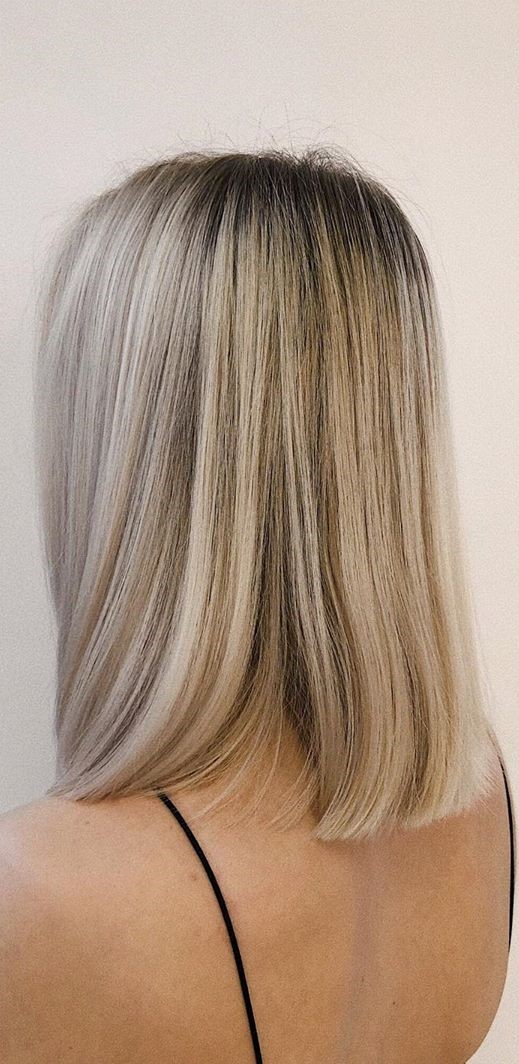

In [15]:
img_s = Image.open('data/hair-data/train/straight/29-wavy-hairstyle-for-medium-hair-B9rxNUdpYR_.jpg')

# Visualize the image img
img_s

## 3. Model

Model structure

In [3]:
class HairCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # (3, 200, 200) -> (32, 198, 198)
        self.conv = nn.Conv2d(
            in_channels=3, out_channels=32,
            kernel_size=3, padding=0, stride=1
        )
        self.pool = nn.MaxPool2d(kernel_size=2)  # (32, 99, 99)
        self.fc1 = nn.Linear(32 * 99 * 99, 64)
        self.fc2 = nn.Linear(64, 1)  # binary output

    def forward(self, x):
        x = F.relu(self.conv(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)  # or x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)          # logits; BCEWithLogitsLoss will apply sigmoid
        return x

In [8]:
# Total number of parameters
params_total = 896 + 20_072_512 + 65
params_total

20073473

In [4]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiating the model
model = HairCNN()
model.to(device)

# Defining the loss function
criterion = nn.BCEWithLogitsLoss()

# Defining the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

## 4. Custom `Dataset` class

#### HairDataset class

In [5]:
class HairDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        """
        data_dir: root folder that contains one subfolder per class
                  e.g. data/hair-data/train/straight, data/hair-data/train/curly
        """
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # class names are the subfolder names ('curly', 'straight')
        self.classes = sorted(os.listdir(data_dir))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}

        for label_name in self.classes:
            label_dir = os.path.join(data_dir, label_name)
            for img_name in os.listdir(label_dir):

                # keep only image files
                if img_name.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".gif", ".webp")):
                    self.image_paths.append(os.path.join(label_dir, img_name))
                    self.labels.append(self.class_to_idx[label_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

#### Preprocessing transforms

In [6]:
train_transforms = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_transforms = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

#### Create train & validation DataLoaders

In [7]:
train_dataset = HairDataset(
    data_dir='data/hair-data/train',
    transform=train_transforms
)

validation_dataset = HairDataset(
    data_dir='data/hair-data/test',
    transform=val_transforms
)

train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)
val_loader = DataLoader(validation_dataset, batch_size=20, shuffle=False)


Helper function for training and evalution loop

In [9]:
def train_and_evaluate(
    model,
    criterion,
    optimizer,
    train_loader,
    val_loader,
    device,
    num_epochs,
    history=None,
):
    """
    Trains `model` for num_epochs and evaluates on val_loader each epoch.
    Appends to an existing `history` dict if provided, otherwise creates one.

    history format:
      {
        'acc':     [...],  # train accuracy per epoch
        'loss':    [...],  # train loss per epoch
        'val_acc': [...],  # val accuracy per epoch
        'val_loss':[...],  # val loss per epoch
      }
    """
    if history is None:
        history = {'acc': [], 'loss': [], 'val_acc': [], 'val_loss': []}

    model.to(device)

    for epoch in range(num_epochs):
        # ----- TRAIN -----
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            # for BCEWithLogitsLoss: float labels with shape (batch_size, 1)
            labels = labels.float().unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

            # predictions for accuracy
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct_train / total_train
        history['loss'].append(epoch_loss)
        history['acc'].append(epoch_acc)

        # ----- VALIDATION -----
        model.eval()
        val_running_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                labels = labels.float().unsqueeze(1)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item() * images.size(0)

                predicted = (torch.sigmoid(outputs) > 0.5).float()
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_epoch_loss = val_running_loss / len(val_loader.dataset)
        val_epoch_acc = correct_val / total_val
        history['val_loss'].append(val_epoch_loss)
        history['val_acc'].append(val_epoch_acc)

        print(
            f"Epoch {len(history['loss'])} "
            f"/ {len(history['loss'])}: "
            f"Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}, "
            f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}"
        )

    return history

## 5. Generators and Training

In [10]:
history = train_and_evaluate(model,
                             criterion,
                             optimizer,
                             train_loader,
                             val_loader,
                             device,
                             num_epochs=10)

Epoch 1 / 1: Loss: 4.5831, Acc: 0.6005, Val Loss: 2.0639, Val Acc: 0.6418
Epoch 2 / 2: Loss: 0.6866, Acc: 0.7728, Val Loss: 0.6961, Val Acc: 0.7015
Epoch 3 / 3: Loss: 0.2460, Acc: 0.9001, Val Loss: 0.8103, Val Acc: 0.6965
Epoch 4 / 4: Loss: 0.1479, Acc: 0.9563, Val Loss: 0.5848, Val Acc: 0.7811
Epoch 5 / 5: Loss: 0.0918, Acc: 0.9788, Val Loss: 0.6582, Val Acc: 0.7711
Epoch 6 / 6: Loss: 0.0541, Acc: 0.9963, Val Loss: 0.6352, Val Acc: 0.7463
Epoch 7 / 7: Loss: 0.0488, Acc: 0.9950, Val Loss: 0.7812, Val Acc: 0.7413
Epoch 8 / 8: Loss: 0.0327, Acc: 0.9975, Val Loss: 0.7054, Val Acc: 0.7612
Epoch 9 / 9: Loss: 0.0212, Acc: 1.0000, Val Loss: 0.7388, Val Acc: 0.7612
Epoch 10 / 10: Loss: 0.0160, Acc: 1.0000, Val Loss: 0.8595, Val Acc: 0.7413


In [11]:
history

{'acc': [0.6004993757802747,
  0.7727840199750312,
  0.9001248439450686,
  0.9563046192259675,
  0.978776529338327,
  0.9962546816479401,
  0.9950062421972534,
  0.9975031210986267,
  1.0,
  1.0],
 'loss': [4.583127339680989,
  0.6866264806109272,
  0.24602069937334525,
  0.14785171902916405,
  0.09184153594737048,
  0.05411541141969583,
  0.048812321862775586,
  0.032677766135643785,
  0.02117995484110047,
  0.015955737309435038],
 'val_acc': [0.6417910447761194,
  0.7014925373134329,
  0.6965174129353234,
  0.7810945273631841,
  0.7711442786069652,
  0.746268656716418,
  0.7412935323383084,
  0.7611940298507462,
  0.7611940298507462,
  0.7412935323383084],
 'val_loss': [2.063880561285929,
  0.6960633573080621,
  0.8102701483896716,
  0.5847793574414832,
  0.6581796470158432,
  0.635203511514979,
  0.7812355273294341,
  0.7054402655753914,
  0.7387873264193531,
  0.8595474468093378]}

#### Median of training accuracy for all epochs

In [13]:
train_acc = np.array(history['acc'])
median_train_acc = np.median(train_acc)
print(f"Median training accuracy: {median_train_acc:.2f}")

Median train acc: 0.99


#### Standard deviation of training loss for all epochs

In [14]:
train_loss = np.array(history['loss'])
std_train_loss   = np.std(train_loss)   # population std
print(f"STD of training loss: {std_train_loss:.3f}")

STD of training loss: 1.344


### Data augmentation

Preprocessing for training set only

In [15]:
train_transforms = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
    transforms.RandomRotation(50),
    transforms.RandomResizedCrop(200,
                                 scale=(0.9, 1.0),
                                 ratio=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(),
])

Generate training loader

In [16]:
train_dataset = HairDataset(
    data_dir='data/hair-data/train',
    transform=train_transforms
)

train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)

Training and evaluation after data augmentation

In [17]:
history = train_and_evaluate(model,
                             criterion,
                             optimizer,
                             train_loader,
                             val_loader,
                             device,
                             num_epochs=10)

Epoch 1 / 1: Loss: 1.4837, Acc: 0.6342, Val Loss: 0.7417, Val Acc: 0.7164
Epoch 2 / 2: Loss: 0.7049, Acc: 0.6742, Val Loss: 0.5656, Val Acc: 0.7363
Epoch 3 / 3: Loss: 0.5474, Acc: 0.7328, Val Loss: 0.5013, Val Acc: 0.7761
Epoch 4 / 4: Loss: 0.5119, Acc: 0.7466, Val Loss: 0.5312, Val Acc: 0.7761
Epoch 5 / 5: Loss: 0.4948, Acc: 0.7690, Val Loss: 0.5456, Val Acc: 0.7562
Epoch 6 / 6: Loss: 0.5653, Acc: 0.7491, Val Loss: 0.5756, Val Acc: 0.7214
Epoch 7 / 7: Loss: 0.4787, Acc: 0.7728, Val Loss: 0.6167, Val Acc: 0.7065
Epoch 8 / 8: Loss: 0.4968, Acc: 0.7591, Val Loss: 0.6579, Val Acc: 0.6915
Epoch 9 / 9: Loss: 0.4848, Acc: 0.7703, Val Loss: 0.4625, Val Acc: 0.7811
Epoch 10 / 10: Loss: 0.5042, Acc: 0.7553, Val Loss: 0.4855, Val Acc: 0.7612


#### Mean of test loss for all the epochs after augmentations

In [18]:
val_loss = np.array(history['val_loss'])
mean_val_loss = val_loss.mean()

print(f"Mean val loss: {mean_val_loss:.3f}")

Mean val loss: 0.568


#### Average of test accuracy for the last 5 epochs after augmentations

In [19]:
val_acc = np.array(history['val_acc'])

# epochs 6–10  -> last 5 entries
last5_val_acc = val_acc[-5:]
avg_last5_val_acc = last5_val_acc.mean()
print(f"Mean of last 5 val acc: {avg_last5_val_acc:.2f}")

Mean of last 5 val acc: 0.73
